# Grover search
## Physics 116 : Quantum Information Science : Dartmouth College 
### J D Whitfield (James.D.Whitfield@dartmouth.edu)

We're going to continue our investigation of the Grover search.  First, load qiskit to make sure everything is working. 

In [1]:
from time import time
start_time=time() #current time in seconds

#BEGIN IMPORTS
import numpy as np
#from qiskit import QuantumProgram
#from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit import *
import matplotlib.pyplot as plt
%matplotlib inline
#END IMPORTS

#BEGIN UTILITIES
def clean(x):
    """Sets values below 1e-10 to zero"""
    return np.round(x*1e10)/1e10

def printnz(x):
    """prints non-zero values (over 1e-10) of a vector"""
    
    temp=clean(x)
    for val in temp:
        if(val!=0):
            print(val)
#END UTILITIES
        
n=3    #number of qubits for database of size N=2**n
       #tested with n=3, n=4. Other values will work 


Next, let us recall the key points of Grover search:
1. Initial state: $s=\frac{1}{\sqrt{N}}\sum_{x=0}^{N-1} |x\rangle$

2. Oracle: $R_w=2|w\rangle \langle w| - \mathbf{1}$, [*phase encoded*]

3. Reflection about state $s$: $R_s=2|s\rangle \langle s| - \mathbf{1}$

4. Grover operator $G=-R_s R_w$
 
The list is also the order in which we will proceed. 

We'll be using $n$ qubits for the database of size $2^n$. Additionally, we will need an additional qubit for the phase oracle, and n qubits for ancillas to implement the multi-controlled gates.

# Initial state

Observe, for $n$ bits there are $2^n$ possible states.  Consistent with this observation we can re-write the general $s$ state as
$s=\frac{1}{\sqrt{N}}\sum_{x_0=0}^{1}\sum_{x_1=0}^1...\sum_{x_n=0}^1 |x_0x_1x_2...x_n \rangle$ to arrive at

$$s=\frac{1}{8}\sum_{x_0=0}^1\sum_{x_1=0}^1\sum_{x_2=0}^1|x_0x_1x_2\rangle$$
  
 

In [2]:
def init_state(qcir):
    """initial state for Grover search, (database,ancillas,orcale_ancila) =(s, 000, +) """
    #Hadamard for database qubits
    for i in range(n):
        qcir.h(q[i])
        
    #oracle applies a Z on the winner state which takes |1> to -|1>
    #so we initialize oracle ancilla to |1> state
    qcir.x(o[0])
    return qcir

The s state will be saved as psi1_s for comparison later.

In [3]:
#SETUP ROUTINE
#
#setup registers
q =QuantumRegister(n,"database")  # quantum registers
o =QuantumRegister(1,"oracle")  # quantum registers
w =QuantumRegister(n-1,"ancillas")  # work space
c =ClassicalRegister(n,"outcomes")  # classical register (for measurement outcomes)
#pick random winner
winner=np.binary_repr(np.random.randint(2**n),n)
#QISKit parameters
N_shots=1000
cirname= 'grover'
#qp=QuantumProgram()                         
qcir=QuantumCircuit(q,o,w,c)
#
# END SETUP

    
qcir=init_state(qcir)    
 

#QISKIT ROUTINE
#qp.add_circuit(cirname,qcir)
backend = BasicAer.get_backend('unitary_simulator') # the device to run on
#result=qp.execute(cirname,backend=backend,shots=N_shots)
result=execute(qcir,backend=backend,shots=N_shots)


#U=result.get_data(cirname)['unitary']
U = result.result().get_unitary(qcir, decimals=3)
psi0 = np.zeros(U.shape[0])
psi0[0]=1.0
#now we have psi as a regular numpy array
#psi = np.dot(result.get_data(cirname)['unitary'], psi0)
psi = np.dot(U, psi0)
#END QISKIT ROUTINE

#save state
psi1_s=psi


# Reflections in general

<img src="./reflection_op.png" style="width: 50%;"/>

<img src="./reflections2.png" style="width: 50%;"/>

# Phase Oracle

To implement the oracle, we can use the extended controlled z gate on an ancilla

In [4]:
def Rw(cir,winner):
    
    if(len(winner)!=n):
        print("error, winner string mis-formatted")
    
    #modify control flags appropriately for secert state
    for k in range(len(winner)):
        
        #NOTE: reading the string in reverse to match QISKit conventions
        if(winner[len(winner)-k-1]=='0'):
            cir.x(q[k])
    
    #BEGIN controlled n z gate (see notebook 'n-Controlled z' for more information)
    if n<2:
        return None;
    
    cir.ccx(q[0],q[1],w[0])

    for k in range(0,n-2):
        cir.ccx(q[k+2],w[k],w[k+1])

    cir.cz(w[n-2],o[0])
    
    for k in range(n-3,-1,-1): #counts from n-2 to 0
        cir.ccx(q[k+2],w[k],w[k+1])
    
    cir.ccx(q[0],q[1],w[0])
    #END controlled n z gate
    
    #unmodify controls appropriately for secert state   
    for k in range(len(winner)):
        if(winner[len(winner)-k-1]=='0'):
            cir.x(q[k])
    
    return cir


# State $R_w|s\rangle$
We should see the marked state with an additional phase factor when examining the final state.  We'll save the state $R_w|s\rangle$ in the variable psi2_rw for comparison purposes

In [5]:
phi0=np.arcsin(1/np.sqrt(2**n));


q =QuantumRegister(n,"database")  # quantum registers
o =QuantumRegister(1,"oracle")  # quantum registers
w =QuantumRegister(n-1,"ancillas")  # work space
c =ClassicalRegister(n,"outcomes")  # classical register (for measurement outcomes)



#pick random winner
winner=np.binary_repr(np.random.randint(2**n),n)

N_shots=1000

cirname= 'grover'
#qp=QuantumProgram()                         
    
    
qcir=QuantumCircuit(q,o,w,c)

#construct the circuit
qcir=init_state(qcir)    
qcir=Rw(qcir,winner)
    
#qp.add_circuit(cirname,qcir)
#backend = 'local_unitary_simulator' # the device to run on
backend = BasicAer.get_backend('unitary_simulator') # the device to run on
result=execute(qcir,backend=backend,shots=N_shots)

U = result.result().get_unitary(qcir, decimals=3)
psi0 = np.zeros(U.shape[0])
psi0[0]=1.0
#now we have psi as a regular numpy array
psi2_rw = np.dot(U, psi0)

#rho=np.outer(psi,psi.conj())
#plot_state(rho,'city')


In [6]:
print("psi1_s=\n")
printnz(psi1_s)
print("\npsi2_rw=\n")
printnz(psi2_rw)

psi1_s=

(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)

psi2_rw=

(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(-0.35400000000000004+0j)
(0.35400000000000004+0j)


Rw looks good. Now is Rs working? <2018 May 5>

# Reflection about s  
More accurately, $\mathbf{1}-2|s\rangle\langle s |$

In [7]:
def Rs(cir):
    """ starts with cccc-z primative and changes basis appropriately"""

    for k in range(n):
        #convert to S state
        cir.h(q[k])
        #convert to cccc-z primative to zeros
        cir.x(q[k])

    #BEGIN controlled n z gate (see notebook 'n-Controlled z' for more information)
    if n<2:
        return None;
    
    cir.ccx(q[0],q[1],w[0])

    for k in range(0,n-3):
        cir.ccx(q[k+2],w[k],w[k+1])

    cir.cz(w[n-3],q[n-1])
    
    for k in range(n-4,-1,-1): #counts from n-3 to 0
        cir.ccx(q[k+2],w[k],w[k+1])
    
    cir.ccx(q[0],q[1],w[0])
    #END controlled n z gate
    
    
    for k in range(n):
        #convert back from zeros
        cir.x(q[k])
        #convert back from S
        cir.h(q[k])
        

    return cir

# State $-R_s|s\rangle$ 

The -Rs gate should change the phase of the s state but otherwise leave it unchanged.  We will test this by running with Rs (psi2_rs) and comparing with $|s\rangle$=psi1 the initial state.  The should be 180$^\circ$ out of phase. 

In [8]:
#SETUP ROUTINE
#
#setup registers
q =QuantumRegister(n,"database")  # quantum registers
o =QuantumRegister(1,"oracle")  # quantum registers
w =QuantumRegister(n-1,"ancillas")  # work space
c =ClassicalRegister(n,"outcomes")  # classical register (for measurement outcomes)
#pick random winner
winner=np.binary_repr(np.random.randint(2**n),n)
#QISKit parameters
N_shots=1000
cirname= 'grover'
#qp=QuantumProgram()                         
qcir=QuantumCircuit(q,o,w,c)
#
# END SETUP

    
qcir=init_state(qcir)    
qcir=Rs(qcir)


#QISKIT ROUTINE
#qp.add_circuit(cirname,qcir)
backend = BasicAer.get_backend('unitary_simulator') # the device to run on
result=execute(qcir,backend=backend,shots=N_shots)

U = result.result().get_unitary(qcir, decimals=3)
psi0 = np.zeros(U.shape[0])
psi0[0]=1.0
#now we have psi as a regular numpy array
psi = np.dot(U, psi0)
#END QISKIT ROUTINE

#save state
psi2_rs=psi



In [9]:
print("psi1_s=\n")
printnz(psi1_s)
print("\npsi2_rs=\n")
printnz(psi2_rs)


psi1_s=

(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)

psi2_rs=

(-0.35400000000000004+0j)
(-0.35400000000000004+0j)
(-0.35400000000000004+0j)
(-0.35400000000000004+0j)
(-0.35400000000000004+0j)
(-0.35400000000000004+0j)
(-0.35400000000000004+0j)
(-0.35400000000000004+0j)


# Analysis


The Grover operator is given by
$$
G=U_{mean}U_o=-R_sR_w.
$$
The Grover search works by evolving the state $s$ toward 
the answer state $|{w}\rangle$ using only a two-dimensional space.  This is because the Grover operator does not evolve state outside of this two-dimensional space.  The states that have no overlap with $|s\rangle$ and $|w\rangle$ are eigenstates of $G$ with eigenvalue $-1$.  Using equations 	 $U_o=R_w=  2|w\rangle\langle w|-\mathbf{1} $ and 	$U_{mean}=-R_s=\mathbf{1}-2|s\rangle\langle s|$.
 to expand $G$ as 
$$
G= 2|s\rangle\langle s|+2|w\rangle\langle w|-4|s\rangle\langle w|s\rangle\langle w|-\mathbf{1}.
$$

If $|{t}\rangle$ has no overlap with $w$ or $s$ then $G|{t}\rangle=-|{t}\rangle$.  Although $|s\rangle$ is a superposition of all states in the database basis, the vectors $w$ and $s$ cannot span the entire space.  An example of such a vector $t$ is any superposition of an even number of states with alternating sign is orthogonal to $|{s}\rangle$, for instance $|t\rangle={\sf H}^{\otimes n}|{1\cdots1}\rangle=(1/\sqrt{N})\sum (-1)^x|{x}\rangle$.  If the superposition $t$  does not include the answer state, then $t$ is in the $N-2$ dimensional space orthogonal to span$\{|{w}\rangle,|{s}\rangle\}$.

Now, consider a new vector $|r\rangle$ such that span$\{|w\rangle,|s\rangle\}=$span$\{|r\rangle,|w\rangle : \langle r|w\rangle=0 \}$.  We express $s$ in the $w,r$ basis as
$$s=\frac{1}{\sqrt{N}}\sum_{x\neq w}^{N-1}|x\rangle+\frac{1}{\sqrt{N}}|w\rangle=\sqrt{\frac{N-1}{N}} \frac{1}{\sqrt{N-1}}\sum_{x\neq w}^{N-1}|x\rangle+\frac{1}{\sqrt{N}}|w\rangle=\sqrt{\frac{N-1}{N}}|r\rangle+\frac{1}{\sqrt{N}}|w\rangle$$
If we let $\phi$ be the angle that $s$ has with $r$, then $\sin\phi=1/\sqrt{N}$ (labelled as c in the figure below) and $\cos\phi=\sqrt{\frac{N-1}{N}}$.  

Next, consider $G|r\rangle=-R_sR_w|r\rangle=R_s|r\rangle=2|s\rangle(\cos\phi)-|r\rangle=2\cos\phi(\cos\phi|r\rangle+\sin\phi|w\rangle-|r\rangle=(2\cos^2\phi-1)|r\rangle+2\cos\phi\sin\phi|w\rangle$.  

These computations can be summarized in the following figure. 

<img src="./geometry3.jpg" style="width: 25%;"/>

The repeated action of the Grover operator advances the angle by an additional $2\phi$ units.  
The initial state has angle $\phi=\sin^{-1}(1/\sqrt{N})$.
Hence, after $k$ iterations, the angle is $\Phi_k=(2k+1)\phi$. 

The probability of correctly guessing the state depends on the angle.  The probaility is given by $$p_w=\sin^2(\Phi_k)$$.
<based on the projection onto $w$ axis squared>

# Theoretical values

0 : pw= 0.12500000000000003
1 : pw= 0.7812500000000001
2 : pw= 0.9453124999999999
3 : pw= 0.330078125


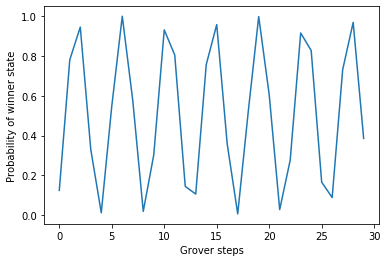

In [10]:
#based on the calculation presented above

phi=np.arcsin(2**(-n/2))

def Phi_k(k): return (2*k+1)*phi;

def p_win(k): return np.sin(Phi_k(k))**2;

#iterations=min(50,int(3**n));
max_steps=3

x=[]
y=[]
for k in range(max_steps*10):
    x.append(k)
    y.append(p_win(k))
    if(k<max_steps+1):
        print(k,": pw=",p_win(k))
        
plt.plot(x,y)
plt.xlabel("Grover steps")
plt.ylabel("Probability of winner state")
plt.show()


## Grover search for winner
We will first extract the states.  Then we will run it with histograms of the simulation results.

In [11]:
grover_states=[]

# SETUP ROUTINE
#
#setup registers
q =QuantumRegister(n,"database")  # quantum registers
o =QuantumRegister(1,"oracle")  # quantum registers
w =QuantumRegister(n-1,"ancillas")  # work space
c =ClassicalRegister(n,"outcomes")  # classical register (for measurement outcomes)
#pick random winner
winner=np.binary_repr(np.random.randint(2**n),n)
#QISKit parameters
N_shots=1000
#
# END SETUP


for grover_steps in range(max_steps):
    
    #RESET QISKIT
    cirname= 'grover'+str(grover_steps)
    #qp=QuantumProgram()                         
    qcir=QuantumCircuit(q,o,w,c)
    #END RESET QISKIT    
        
    
    qcir=init_state(qcir)    
    
    for k in range(grover_steps):
        qcir=Rw(qcir,winner)
        qcir=Rs(qcir)



    #QISKIT ROUTINE
    #qp.add_circuit(cirname,qcir)
    backend = BasicAer.get_backend('unitary_simulator') # the device to run on
    result = execute(qcir,backend=backend,shots=N_shots)

    U = result.result().get_unitary(qcir, decimals=3)
    psi0 = np.zeros(U.shape[0])
    psi0[0]=1.0
    #now we have psi as a regular numpy array
    psi = np.dot(U, psi0)
    #END QISKIT ROUTINE
    
    grover_states.append(psi)


In [12]:
for k in range(max_steps): 
    print("\n--\nafter ",k," steps:\n")
    printnz(grover_states[k])


--
after  0  steps:

(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)
(0.35400000000000004+0j)

--
after  1  steps:

(-0.17700000000000002+0j)
(-0.17700000000000002+0j)
(-0.17700000000000002+0j)
(-0.17700000000000002+0j)
(-0.884+0j)
(-0.17700000000000002+0j)
(-0.17700000000000002+0j)
(-0.17700000000000002+0j)

--
after  2  steps:

(-0.08800000000000001+0j)
(-0.08800000000000001+0j)
(-0.08800000000000001+0j)
(-0.08800000000000001+0j)
(0.9720000000000001+0j)
(-0.08800000000000001+0j)
(-0.08800000000000001+0j)
(-0.08800000000000001+0j)


In [13]:
# SETUP ROUTINE
#
#setup registers
q =QuantumRegister(n,"database")  # quantum registers
o =QuantumRegister(1,"oracle")  # quantum registers
w =QuantumRegister(n-1,"ancillas")  # work space
c =ClassicalRegister(n,"outcomes")  # classical register (for measurement outcomes)
#pick random winner
winner=np.binary_repr(np.random.randint(2**n),n)
#QISKit parameters
N_shots=1000
#
# END SETUP


for grover_steps in range(max_steps):
    
    #RESET QISKIT
    cirname= 'grover'+str(grover_steps)
    #qp=QuantumProgram()                         
    qcir=QuantumCircuit(q,o,w,c)
    #END RESET QISKIT    
        
    
    qcir=init_state(qcir)    
    
    for k in range(grover_steps):
        qcir=Rw(qcir,winner)
        qcir=Rs(qcir)

    #measure output (needed if we're not using the unitary generated)
    for k in range(n):
        qcir.measure(q[k],c[k])

    #QISKIT ROUTINE
    #qp.add_circuit(cirname,qcir)
    #backend = BasicAer.get_backend('unitary_simulator') # the device to run on
    backend = BasicAer.get_backend('qasm_simulator')
    result= execute(qcir,backend=backend,shots=N_shots)

    ## ANALYSIS SUBROUTINE
    results_dict=result.result().get_counts()
    pw=results_dict[winner]/N_shots
    
    #plot the probabilities
    plot_histogram(results_dict)
    
    #report probability and expectation values
    print(cirname,": pw=",pw," and pw_expected=",p_win(grover_steps),"\n")
    
    #plot the probabilities
    #plot_histogram(results_dict)
    ## END ANALYSIS SUBROUTINE
    
    #END QISKIT ROUTINE
    


grover0 : pw= 0.113  and pw_expected= 0.12500000000000003 

grover1 : pw= 0.782  and pw_expected= 0.7812500000000001 

grover2 : pw= 0.95  and pw_expected= 0.9453124999999999 



000


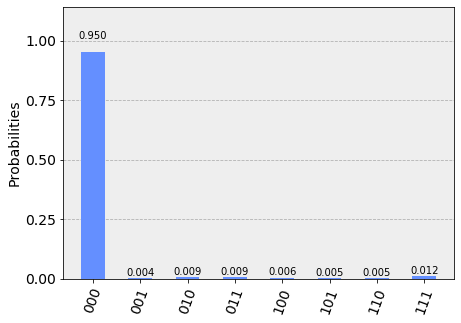

In [14]:
print(winner)

plot_histogram(results_dict)

In [15]:
end_time=time()  #time in seconds
print("Total notebook runtime was ",end_time-start_time," seconds for n=",n) 

Total notebook runtime was  10.523730039596558  seconds for n= 3


# Notes
Took 0 minutes 18 seconds at n=3  on MS Surface (2017)
Took 5 minutes 51 seconds at n=4 on MS Surface (2017)

James.D.Whitfield@dartmouth.edu : Physics 116 : Quantum information science : 2018